# 1. Data Gathering - 부동산 데이터 구하기

In [2]:
# data gathering 샘플 코드
from PublicDataReader import Kbland
api = Kbland()
params = {
    "월간주간구분코드": "01",
    "매물종별구분": "01",
    "매매전세코드": "01",
    "지역코드": "11",
    "기간": "1",
}
df = api.get_price_index(**params)
df.tail()

,월간주간구분,매물종별구분,거래구분,지역코드,지역명,날짜,가격지수
333,월간,아파트,매매,1174000000,강동구,2022-11-01,97.654526
334,월간,아파트,매매,1174000000,강동구,2022-12-01,95.464474
335,월간,아파트,매매,1174000000,강동구,2023-01-01,91.261565
336,월간,아파트,매매,1174000000,강동구,2023-02-01,90.342080
337,월간,아파트,매매,1174000000,강동구,2023-03-01,89.996191


2) data.go.kr 의 데이터 읽어오기: https://ai-creator.tistory.com/24

## 목적 : 강남구의 아파트 매매 가격 증감여부 예측

## 크롤링 데이터 목록

### 1) 국토교통부_아파트매매 실거래 상세 자료

### 2) 국토교통부_토지 매매 신고 자료

### 3) FinanceDataReader를 이용한 KOSPI시세정보

### 4) 한국은행경제통계시스템 국민계정에 있는 주택담보대출(LTV) 금리 csv 파일(https://ecos.bok.or.kr/#/SearchStat)

 강남구의 아파트 매매 가격 증감여부를 예측하기 위해 아파트 매매에 관한 데이터를 가져오고, 이 외에 훈련과 예측에 사용될 자료로 토지 매매 자료, kospi 자료, 주택담보대출 금리 자료를 사용하였습니다.

In [80]:
import os
import urllib.request
import datetime
import time
import pandas as pd
import xml.etree.ElementTree as ET
import FinanceDataReader as fdr

ServiceKey = '4GzbYliW2Qnh%2BUFwcZYKIU2Hd6DNaFPDySa%2FCH7KRyjCa6JZZtpLAmYCytOspdPbPm3c5RCeZIbC1j6RaUUsyw%3D%3D' # 서비스 키

# url request
def getRequestUrl(url):
    req = urllib.request.Request(url)
    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            #print("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None

    
    
# data.go.kr의 국토교통부_아파트매매 실거래 상세 자료 api / 형식(xml)
def getAptTransItem(deal_ymd, lawd_cd): # 요청
    service_url = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev'

    parameters = "?_type=xml&ServiceKey=" + ServiceKey #인증키
    parameters += "&DEAL_YMD=" + deal_ymd # 거래연월
    parameters += "&LAWD_CD=" + lawd_cd # 지역코드
                                  
    url = service_url + parameters
    retData = getRequestUrl(url)
    if (retData == None): # 비어있는 경우
        return None
    else:
        tree = ET.ElementTree(ET.fromstring(retData)) #xml
        return tree

def getAptTransService(lawd, lawd_cd, nStartYear, nEndYear): # 파싱
    result = []
    dataEND = "{0}{1:0>2}". format(str(nEndYear), str(12))
    isDataEnd = 0    
    for year in range(nStartYear, nEndYear+1):
        for month in range(1, 13):
            yyyymm = "{0}{1:0>2}".format(str(year), str(month))
            xmlData = getAptTransItem(yyyymm, lawd_cd)
            
            if (xmlData == None):
                continue
            
            header = xmlData.find('header')
            resultCode = header.findtext('resultCode')
            
            if resultCode == '00':
                items = xmlData.findall('.//item')
                # 마지막 항목일 경우
                if len(items) == 0:
                    isDataEnd = 1
                    dataEND = "{0}{1:0>2}".format(str(year), str(month-1))
                    break

                for item in items:
                    deal_ammount = item.findtext('거래금액')
                    build_year = item.findtext('건축년도')
                    floor = item.findtext('층')
                    area = item.findtext('전용면적')
                    result.append([lawd, yyyymm, deal_ammount, build_year, floor, area])
    return (lawd, result, dataEND)

def generateAptTransSerice(lawd_cd, nStartYear, nEndYear): # 데이터 프레임 생성 후 csv 파일로 저장
    result = []
    result_dfs = []
    
    for lawd in lawd_cd.keys():
        local, result, dataEND = getAptTransService(lawd, lawd_cd[lawd], nStartYear, nEndYear) 
  
        columns = ["지역명", "아파트 거래연월", "아파트 거래금액(만원)", "아파트 건축년도", "아파트 층", "아파트 면적"]
        result_df = pd.DataFrame(result, columns = columns)
        result_dfs.append(result_df)
        
    combined_df = pd.concat(result_dfs)
    
    print('%d_%s_아파트매매량.csv' % (nStartYear, dataEND))
    print(combined_df.head(10), '\n')
        
    #파일저장 : csv 파일
    combined_df.to_csv('./%d_%s_아파트매매량.csv' % (nStartYear, dataEND), index=False, encoding='cp949')

    
    
# data.go.kr의 국토교통부_토지 매매 신고 조회 서비스 / 형식(xml)
def getLandTransItem(deal_ymd, lawd_cd): # 요청
    service_url = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcLandTrade'

    parameters = "?_type=xml&ServiceKey=" + ServiceKey #인증키
    parameters += "&DEAL_YMD=" + deal_ymd # 거래연월
    parameters += "&LAWD_CD=" + lawd_cd # 지역코드
                                  
    url = service_url + parameters
    retData = getRequestUrl(url)
    if (retData == None): # 비어있는 경우
        return None
    else:
        tree = ET.ElementTree(ET.fromstring(retData)) # xml
        return tree

def getLandTransService(lawd, lawd_cd, nStartYear, nEndYear): # 파싱
    result = []
    dataEND = "{0}{1:0>2}". format(str(nEndYear), str(12))
    isDataEnd = 0    
    for year in range(nStartYear, nEndYear+1):
        for month in range(1, 13):
            yyyymm = "{0}{1:0>2}".format(str(year), str(month))
            xmlData = getLandTransItem(yyyymm, lawd_cd)
            
            if (xmlData == None):
                continue
            
            header = xmlData.find('header')
            resultCode = header.findtext('resultCode')
            
            if resultCode == '00':
                items = xmlData.findall('.//item')
                # 마지막 항목일 경우
                if len(items) == 0:
                    isDataEnd = 1
                    dataEND = "{0}{1:0>2}".format(str(year), str(month-1))
                    break

                for item in items:
                    deal_ammount = item.findtext('거래금액')
                    result.append([lawd, yyyymm, deal_ammount])
    return (lawd, result, dataEND)

def generateLandTransSerice(lawd_cd, nStartYear, nEndYear): # 데이터 프레임 생성 후 csv 파일로 저장
    result = []
    result_dfs = []
    
    for lawd in lawd_cd.keys():
        local, result, dataEND = getLandTransService(lawd, lawd_cd[lawd], nStartYear, nEndYear) 
  
        columns = ["지역명", "토지 거래연월", "토지 거래금액(만원)"]
        result_df = pd.DataFrame(result, columns = columns)
        result_dfs.append(result_df)
        
    combined_df = pd.concat(result_dfs)
    
    print('%d_%s_토지매매량.csv' % (nStartYear, dataEND))
    print(combined_df.head(10), '\n')
        
    #파일저장 : csv 파일
    combined_df.to_csv('./%d_%s_토지매매량.csv' % (nStartYear, dataEND), index=False, encoding='cp949')



# FinanceDataReader를 이용한 kospi시세정보 (출처 : https://wikidocs.net/172650)
def generateStockMarketSerice(nStartYear, nEndYear):
    # yyyy-mm-dd 문자열 형식으로 변환
    start_date = f"{nStartYear}-01-01"
    end_date = f"{nEndYear}-12-31"
    df = fdr.DataReader('KS11', start_date, end_date)
    
    print('%d_%d_KOSPI.csv' % (nStartYear, nEndYear))
    print(df.head(10), '\n')
    
    #파일저장 : csv 파일
    df.to_csv('./%d_%d_KOSPI.csv' % (nStartYear, nEndYear), index=True, encoding='cp949')

    
    
# 한국은행경제통계시스템 국민계정에 있는 주택담보대출(LTV) 금리 csv 파일 (https://ecos.bok.or.kr/#/SearchStat)
def generateLTV():
    df = pd.read_csv('예금은행 대출금리(신규취급액 기준)_21204509.csv', encoding='utf-8')
    print('예금은행 대출금리(신규취급액 기준)_21204509.csv')
    print(df.head(10))   
    
def main():
    lawd_cd = {'강남구': '11680'} # 딕셔너리
    nStartYear = 2018
    nEndYear = 2022
    
    generateAptTransSerice(lawd_cd, nStartYear, nEndYear)
    generateLandTransSerice(lawd_cd, nStartYear, nEndYear)
    generateStockMarketSerice(nStartYear, nEndYear)
    generateLTV()

if __name__ == '__main__':
    main()
          

2018_202212_아파트매매량.csv
   지역명 아파트 거래연월 아파트 거래금액(만원) 아파트 건축년도 아파트 층   아파트 면적
0  강남구   201801       80,000     2003     5    59.77
1  강남구   201801       83,500     1997     6    59.99
2  강남구   201801      108,000     2003    14   132.88
3  강남구   201801      180,000     2010    18   121.54
4  강남구   201801      151,000     2006     3  84.9097
5  강남구   201801       35,000     1996     6    39.89
6  강남구   201801      165,000     2010    21   105.89
7  강남구   201801       89,000     2007     7    84.96
8  강남구   201801      127,800     2005     5     59.4
9  강남구   201801       53,000     2002    12    52.31 

2018_202212_토지매매량.csv
   지역명 토지 거래연월 토지 거래금액(만원)
0  강남구  201801     288,000
1  강남구  201801   2,430,000
2  강남구  201801     635,000
3  강남구  201801     341,320
4  강남구  201801     749,000
5  강남구  201801     644,729
6  강남구  201801      42,267
7  강남구  201801      37,500
8  강남구  201801      56,400
9  강남구  201801      45,000 

2018_2022_KOSPI.csv
                   Open         High          Low  

## 1.2 데이터구조 문서화( 주피터 노트북에 표현)

- 1) 2018_202212_아파트매매량.csv

    |컬럼명|데이터타입|설명|
    |------|----------|----|
    |아파트 거래연월|int|거래된 년, 월, 일|
    |아파트 거래금액(만원)|int object|거래금액(만원)|
    |아파트 건축년도|int|건축년도|
    |아파트 층|int|층|
    |아파트 면적|float|면적|

- 2) 2018_202212_토지매매량.csv

    |컬럼명|데이터타입|설명|
    |------|----------|----|
    |지역명|string object|지역명|
    |토지 거래연월|int|거래된 년, 월, 일|
    |토지 거래금액(만원)|int object|거래금액(만원)|

- 3) 2018_202212_전월세.csv

    |컬럼명|데이터타입|설명|
    |------|----------|----|
    |지역명|string object|지역명|
    |전월세 거래연월|int|거래된 년, 월, 일|
    |월세(만원)|int object|거래금액(만원), 전세일 경우 월세는 0으로 표시|
    |보증금(만원)|int object|거래금액(만원)|
    
- 4) 2018_2022_KOSPI.csv

    |컬럼명|데이터타입|설명|
    |------|----------|----|
    |Date|datetime object|거래된 년, 월, 일, 주말, 공휴일과 같은 장이 열리지 않는 날은 포함되지 않는다|
    |Open|float|개장가격|
    |High|float|최고점|
    |Low|float|최저점|
    |Close|float|종가|
    |Adj Close|float|조정종가|
    |Volume|int|거래량|
    
    
- 5) 예금은행 대출금리(신규취급액 기준)_21204509.csv

    |컬럼명|데이터타입|설명|
    |------|----------|----|
    |변환|datetime object|2018년 1월부터 2022년 12월 까지, 년, 월 및 매월 1일로 되어있는 데이터|
    |원자료|float|주택담보대출 금리|


# 2. 데이터 변환하기 (1번 데이터 이용)
1) 프로그램 요구사항: 
- 날짜를 이용하여 계절 컬럼을 추가하라.
- 기타 분석목적에 필요한 컬럼을 계산하여 추가하거나, 다른 데이터를 구하여 결합하여 추가하라.
  - 예) 물가상승율, 이자율, 지하철역 개통시기, 지하철역과의 거리, 초등학교의 수, 초등학교와의 거리, 고등학교의 수, 고등학교와의 거리 
  

2) 출력사항
- 데이터의 상위 10개를 출력결과를 포함하라. 

 
## 2.1 상관관계표 구하기
1) 프로그램 요구사항: 
- 데이터 중 5종 이상의 수치애트리뷰트 들간의 상관관계 매트릭스를 구하하는 프로그램을 작성하라.
  예) 가격, 가격지수, 가격증감율, 가격지수 증감율, 이자율, 물가상승율
  
2) 문서화 요구사항:     
- 구한 데이터의 상관관계 매트릭스를 주피터 노트북에 포함하라.
 
 
## 2.2 산포도 그리기
1) 프로그램 요구사항: 
- 2.1의 상관관계 중 상관관계가 높은 (애트리뷰트 페어) 2개의 의 산포도 2개를 그려라.
    
2) 문서화 요구사항:     
- 구한 산포도를 주피터 노트북에 포함하라.

## 2.3 차트그리기
1) 5종 이상의 수치데이터의 시계열 차트(꺽은선 그래프)를 그려라.
  즉, x축을 시간으로, y축은 수치데이터로, 5종의 값들은 값의 범주(카테고리)로 그리라. 

2)시간을 고정하고, 수치형 데이터의 구간을 적절히 정하여, 히스토그램을 그려라.

## 2. 데이터 변환하기 (1번 데이터 이용)
1) 프로그램 요구사항: 
- 날짜를 이용하여 계절 컬럼을 추가하라.
- 기타 분석목적에 필요한 컬럼을 계산하여 추가하거나, 다른 데이터를 구하여 결합하여 추가하라.
  - 예) 물가상승율, 이자율, 지하철역 개통시기, 지하철역과의 거리, 초등학교의 수, 초등학교와의 거리, 고등학교의 수, 고등학교와의 거리 
  

2) 출력사항
- 데이터의 상위 10개를 출력결과를 포함하라.

### 진행사항
- 범주형 데이터로 아파트 거래금액 증감여부, LTV 증감여부, 계절, 아파트 연식을 추가했습니다.
- 아파트 거래금액과 토지 거래금액의 사분위수를 이용한 아웃라이어들을 제거했습니다.
- KOSPI에서 종가와 거래량만 가져오기로 정했습니다.
- 모든 데이터는 월을 기준으로 하고, merge는 거래연월을 기준으로 빈 컬럼은 이전값을 복사하는 방식으로 fit했습니다.

In [158]:
import pandas as pd

df_aptTrans = pd.read_csv('2018_202212_아파트매매량.csv', encoding='cp949', low_memory=False,
                         converters={'아파트 거래금액(만원)': lambda x: int(x.replace(',', ''))}) # 숫자에서 , 제거하고 int형으로 변환

# 아파트 거래금액 증감여부 생성
df_aptTrans['diff'] = df_aptTrans['아파트 거래금액(만원)'].diff()
df_aptTrans['증감'] = df_aptTrans['diff'].apply(lambda x: '증가' if x > 0 else '감소')
df_aptTrans.iloc[0, df_aptTrans.columns.get_loc('증감')] = '증가' # 첫번째 행 '증감' 값을 '증가'로 설정

# 아파트 거래금액(만원) 아웃라이어 제거
q1 = df_aptTrans['아파트 거래금액(만원)'].quantile(0.25)
q3 = df_aptTrans['아파트 거래금액(만원)'].quantile(0.75)
iqr = q3 - q1
df_aptTrans = df_aptTrans[(df_aptTrans['아파트 거래금액(만원)'] >= q1 - 1.5*iqr) & 
                          (df_aptTrans['아파트 거래금액(만원)'] <= q3 + 1.5*iqr)]

df_landTrans = pd.read_csv('2018_202212_토지매매량.csv', encoding='cp949', low_memory=False,
                           converters={'토지 거래금액(만원)': lambda x: int(x.replace(',', ''))}) # 숫자에서 , 제거하고 int형으로 변환

# 토지 거래금액(만원) 아웃라이어 제거
q1 = df_landTrans['토지 거래금액(만원)'].quantile(0.25)
q3 = df_landTrans['토지 거래금액(만원)'].quantile(0.75)
iqr = q3 - q1
df_landTrans = df_landTrans[(df_landTrans['토지 거래금액(만원)'] >= q1 - 1.5*iqr) & (df_landTrans['토지 거래금액(만원)'] <= q3 + 1.5*iqr)]

df_KOSPI = pd.read_csv('2018_2022_KOSPI.csv', usecols=['Date', 'Close', 'Volume'], encoding='cp949', low_memory=False)

df_LTV = pd.read_csv('예금은행 대출금리(신규취급액 기준)_21204509.csv', encoding='utf-8', low_memory=False)

# LTV 증감여부 생성
df_LTV['diff1'] = df_LTV['원자료'].diff()
df_LTV['LTV 증감'] = df_LTV['diff1'].apply(lambda x: '증가' if x > 0 else '감소')
df_LTV.iloc[0, df_LTV.columns.get_loc('LTV 증감')] = '감소' # 첫번째 행 '증감' 값을 '감소'로 설정

# 계절 정보를 매핑하기 위한 함수
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

#  연식 정보를 매핑하기 위한 함수
def categorize_building_age(year):
    if year['아파트 건축년도'] < 2003:
        return '구축'
    elif year['아파트 건축년도'] >= 2003 and year['아파트 건축년도'] <= 2018:
        return '일반'
    else:
        return '신축'

# 'Date' column을 datetime 타입으로 변환
df_KOSPI['Date'] = pd.to_datetime(df_KOSPI['Date'])

# 'Year' 컬럼 추가
df_KOSPI['Year'] = df_KOSPI['Date'].dt.year

# 'Month' 컬럼 추가
df_KOSPI['Month'] = df_KOSPI['Date'].dt.month

# 월별 Cloas, Volune 컬럼의 평균값을 구하여 새로운 컬럼에 추가
df_KOSPI['Close_avg'] = df_KOSPI.groupby(['Year', 'Month'])['Close'].transform(lambda x: round(x.mean(), 1))
df_KOSPI['Volume_avg'] = df_KOSPI.groupby(['Year', 'Month'])['Volume'].transform(lambda x: round(x.mean(), 1))
df_KOSPI['Year_Month'] = df_KOSPI.apply(lambda x: f"{x['Year']}{x['Month']:02}", axis=1)

# 'Year', 'Month', 'Close_avg', 'Volume_avg' 열 추출
df_KOSPI_avg = df_KOSPI[['Year_Month', 'Close_avg', 'Volume_avg']].copy()

# 중복값 제거
df_KOSPI_avg.drop_duplicates(['Year_Month'], keep='first', inplace=True, ignore_index = True)

# 거래연월을 모두 datetime 화
df_aptTrans['거래연월'] = pd.to_datetime(df_aptTrans['아파트 거래연월'], format='%Y%m')
df_landTrans['거래연월'] = pd.to_datetime(df_landTrans['토지 거래연월'], format='%Y%m')
df_KOSPI_avg['거래연월'] = pd.to_datetime(df_KOSPI_avg['Year_Month'], format='%Y%m')
df_LTV['거래연월'] = pd.to_datetime(df_LTV['변환'], format='%Y/%m')

# 거래연월을 기준으로 merge
df1 = pd.merge(df_aptTrans, df_landTrans, on='거래연월')
df2 = pd.merge(df1, df_KOSPI_avg, on = '거래연월')
result_df = pd.merge(df2, df_LTV, on = '거래연월')
result_df['계절'] = result_df['거래연월'].dt.month.apply(get_season)
result_df['연식'] = result_df.apply(categorize_building_age, axis=1)

# 필요없는 열 버리기
result_df.drop('지역명_x', axis=1, inplace=True)
result_df.drop('지역명_y', axis=1, inplace=True)
result_df.drop('아파트 거래연월', axis=1, inplace=True)
result_df.drop('토지 거래연월', axis=1, inplace=True)
result_df.drop('Year_Month', axis=1, inplace=True)
result_df.drop('변환', axis=1, inplace=True)
result_df.drop('diff', axis=1, inplace=True)
result_df.drop('diff1', axis=1, inplace=True)

# 열 이름 바꾸기
result_df.rename(columns={'원자료': 'LTV'}, inplace=True)

# 새로운 csv 파일로 저장
result_df.to_csv('부동산종합데이터.csv', index=True, encoding='cp949')
result_df.head(10)

,아파트 거래금액(만원),아파트 건축년도,아파트 층,아파트 면적,증감,거래연월,토지 거래금액(만원),Close_avg,Volume_avg,LTV,LTV 증감,계절,연식
0,80000,2003,5,59.77,증가,2018-01-01,288000,2520.9,375154.5,3.47,증가,겨울,일반
1,80000,2003,5,59.77,증가,2018-01-01,635000,2520.9,375154.5,3.47,증가,겨울,일반
2,80000,2003,5,59.77,증가,2018-01-01,341320,2520.9,375154.5,3.47,증가,겨울,일반
3,80000,2003,5,59.77,증가,2018-01-01,749000,2520.9,375154.5,3.47,증가,겨울,일반
4,80000,2003,5,59.77,증가,2018-01-01,644729,2520.9,375154.5,3.47,증가,겨울,일반
5,80000,2003,5,59.77,증가,2018-01-01,42267,2520.9,375154.5,3.47,증가,겨울,일반
6,80000,2003,5,59.77,증가,2018-01-01,37500,2520.9,375154.5,3.47,증가,겨울,일반
7,80000,2003,5,59.77,증가,2018-01-01,56400,2520.9,375154.5,3.47,증가,겨울,일반
8,80000,2003,5,59.77,증가,2018-01-01,45000,2520.9,375154.5,3.47,증가,겨울,일반
9,80000,2003,5,59.77,증가,2018-01-01,80000,2520.9,375154.5,3.47,증가,겨울,일반


## 2.1 상관관계표 구하기
1) 프로그램 요구사항: 
- 데이터 중 5종 이상의 수치애트리뷰트 들간의 상관관계 매트릭스를 구하하는 프로그램을 작성하라.
  예) 가격, 가격지수, 가격증감율, 가격지수 증감율, 이자율, 물가상승율
  
2) 문서화 요구사항:     
- 구한 데이터의 상관관계 매트릭스를 주피터 노트북에 포함하라.

### 진행사항
- 한번에 여러 데이터프레임을 받아 매트릭스를 생성 할 수 있도록 correlation_matrix 함수를 작성하였습니다.

In [4]:
import pandas as pd
import math
from typing import List

Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    assert len(v) == len(w), "vectors must be same length"
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: Vector) -> float:
    return dot(v, v)

def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

def de_mean(xs: List[float]) -> List[float]:
    x_bar = mean(xs)
    return [x - x_bar for x in xs]

def variance(xs: List[float]) -> float:
    assert len(xs) >= 2, "variance requires at least two elements"
    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1) # n-1 instead of n when sampled data

def standard_deviation(xs: List[float]) -> float:
    return math.sqrt(variance(xs))

def covariance(xs: List[float], ys: List[float]) -> float:
    assert len(xs) == len(ys), "xs and ys must have same number of elements"
    return dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)

def correlation(xs: List[float], ys: List[float]) -> float:
    stdev_x = standard_deviation(xs)
    stdev_y = standard_deviation(ys)
    if stdev_x > 0 and stdev_y > 0:
        corr = covariance(xs, ys) / stdev_x / stdev_y
        return min(1.0, max(corr, -1.0)) # limit correlation coefficient to [-1, 1]
    else:
        return 0    # if no variation, correlation is zero

# 여러 데이터 프레임을 받을 수 있도록 하는 함수
def correlation_matrix(*args: List[float]) -> pd.DataFrame: 
    n = len(args)
    corr_matrix = [[None] * n for _ in range(n)]

    for i in range(n):
        for j in range(i, n):
            corr = correlation(args[i], args[j])
            corr_matrix[i][j] = corr
            corr_matrix[j][i] = corr

    # 컬럼 및 인덱스 지정
    return pd.DataFrame(corr_matrix, columns=[f"var_{i+1}" for i in range(n)], index=[f"var_{i+1}" for i in range(n)])

df_aptE = pd.read_csv('부동산종합데이터.csv', encoding='cp949', low_memory=False,
                      converters={'아파트 거래금액(만원)': lambda x: int(x.replace(',', '')),
                                  '토지 거래금액(만원)': lambda x: int(x.replace(',', ''))})

# 계절을 숫자로 변환
season_dict = {'봄': 1, '여름': 2, '가을': 3, '겨울': 4}
df_aptE['계절'] = df_aptE['계절'].map(season_dict)

build_dict = {'구축': 1, '일반': 2, '신축': 3}
df_aptE['연식'] = df_aptE['연식'].map(build_dict)

rate_dict = {'증가': 1, '감소' : 2}
df_aptE['증감'] = df_aptE['증감'].map(rate_dict)

df_aptE['LTV 증감'] = df_aptE['LTV 증감'].map(rate_dict)

var_1 = df_aptE['아파트 거래금액(만원)']
var_2 = df_aptE['아파트 층']
var_3 = df_aptE['아파트 면적']
var_4 = df_aptE['토지 거래금액(만원)']
var_5 = df_aptE['Close_avg']
var_6 = df_aptE['Volume_avg']
var_7 = df_aptE['LTV']
var_8 = df_aptE['계절']
var_9 = df_aptE['연식']
var_10 = df_aptE['증감']
var_11 = df_aptE['LTV 증감']

correlation_matrix(var_1, var_2, var_3, var_4, var_5, var_6, var_7, var_8, var_9, var_10, var_11)

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11
var_1,1.000000,0.200209,0.696436,-0.004277,0.005266,0.076023,0.047896,0.090391,0.186992,-0.522730,0.012297
var_2,0.200209,1.000000,-0.010267,-0.021948,-0.013324,0.002487,0.034895,0.054823,0.016512,-0.188430,-0.014966
var_3,0.696436,-0.010267,1.000000,0.021807,-0.120682,-0.032071,-0.058694,0.094619,0.047613,-0.445632,-0.085784
var_4,-0.004277,-0.021948,0.021807,1.000000,0.022988,0.004303,-0.086008,0.038524,-0.011861,-0.005757,-0.035422
var_5,0.005266,-0.013324,-0.120682,0.022988,1.000000,0.620959,-0.065496,0.041405,-0.001563,0.009334,0.484755
var_6,0.076023,0.002487,-0.032071,0.004303,0.620959,1.000000,-0.499743,-0.058380,0.001706,0.037064,0.350315
var_7,0.047896,0.034895,-0.058694,-0.086008,-0.065496,-0.499743,1.000000,0.138874,-0.024867,-0.008601,-0.123157
var_8,0.090391,0.054823,0.094619,0.038524,0.041405,-0.058380,0.138874,1.000000,-0.101590,-0.052552,0.035505
var_9,0.186992,0.016512,0.047613,-0.011861,-0.001563,0.001706,-0.024867,-0.101590,1.000000,-0.156462,0.020667
var_10,-0.522730,-0.188430,-0.445632,-0.005757,0.009334,0.037064,-0.008601,-0.052552,-0.156462,1.000000,-0.029498


## 2.2 산포도 그리기
1) 프로그램 요구사항: 
- 2.1의 상관관계 중 상관관계가 높은 (애트리뷰트 페어) 2개의 의 산포도 2개를 그려라.
    
2) 문서화 요구사항:     
- 구한 산포도를 주피터 노트북에 포함하라.

### 진행사항
- 상관계수가 가장 높은 아파트 거래금액(만원)과 아파트 면적 페어, Close_avg과 Volume_avg의 페어로 진행했습니다.
- 올바른 상관관계를 보기 위해 스케일링을 진행했습니다.
- 아파트 거래금액(만원)과 아파트 면적 페어의 데이터 수가 많아 모두 표현하면 차트를 다 가리므로 월별 상위 20개만 표시하도록 했습니다.

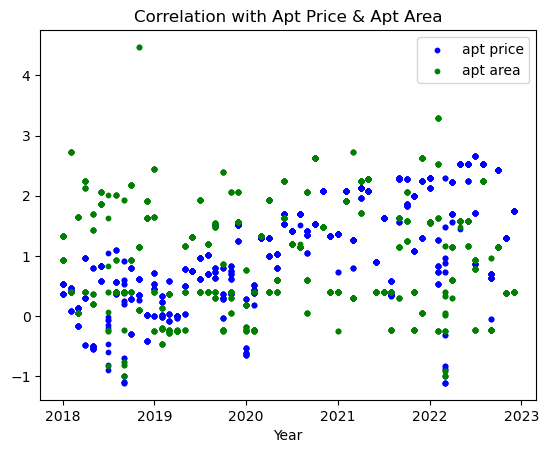

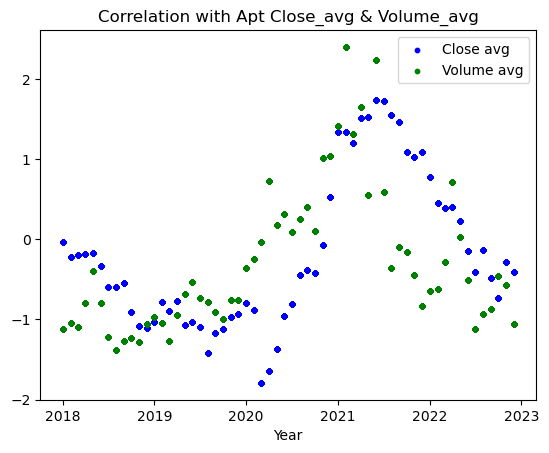

In [129]:
#아파트 거래금액(만원)과 아파트 면적 페어, Close_avg과 Volume_avg의 페어
import pandas as pd
from matplotlib import pyplot as plt

df_aptE = pd.read_csv('부동산종합데이터.csv', encoding='cp949', low_memory=False,
                      converters={'아파트 거래금액(만원)': lambda x: int(x.replace(',', '')),
                                  '토지 거래금액(만원)': lambda x: int(x.replace(',', ''))})

df_aptE['거래연월'] = pd.to_datetime(df_aptE['거래연월'], format='%Y/%m')

# 아파트 거래금액(만원) 스케일링
df_aptE['아파트 거래금액(만원)'] = (df_aptE['아파트 거래금액(만원)'] - df_aptE['아파트 거래금액(만원)'].mean()) / df_aptE['아파트 거래금액(만원)'].std()

# 아파트 면적 스케일링
df_aptE['아파트 면적'] = (df_aptE['아파트 면적'] - df_aptE['아파트 면적'].mean()) / df_aptE['아파트 면적'].std()

# 각 연월에 대한 상위 20개 데이터 추출
df_top1 = df_aptE.groupby('거래연월').apply(lambda x: x.nlargest(20, '아파트 거래금액(만원)')).reset_index(drop=True)

# 그래프 그리기
plt.figure(1)
for group_name, group_data in df_top1.groupby('거래연월'):
    plt.scatter(group_data['거래연월'], group_data['아파트 거래금액(만원)'], label='apt price', color='blue', s=10)
    plt.scatter(group_data['거래연월'], group_data['아파트 면적'], label='apt area', color='green', s=10)
plt.title('Correlation with Apt Price & Apt Area')
plt.xlabel('Year')
plt.legend(labels=['apt price', 'apt area'])

# Close_avg 스케일링
df_aptE['Close_avg'] = (df_aptE['Close_avg'] - df_aptE['Close_avg'].mean()) / df_aptE['Close_avg'].std()

# Volume_avg 스케일링
df_aptE['Volume_avg'] = (df_aptE['Volume_avg'] - df_aptE['Volume_avg'].mean()) / df_aptE['Volume_avg'].std()

# 그래프 그리기
plt.figure(2)
plt.scatter(df_aptE['거래연월'], df_aptE['Close_avg'], label='Close avg', color='blue', s=10)
plt.scatter(df_aptE['거래연월'], df_aptE['Volume_avg'], label='Volume avg', color='green', s=10)
plt.title('Correlation with Apt Close_avg & Volume_avg')
plt.xlabel('Year')
plt.legend(labels=['Close avg', 'Volume avg'])

plt.show()

## 2.3 차트그리기
1) 5종 이상의 수치데이터의 시계열 차트(꺽은선 그래프)를 그려라.
  즉, x축을 시간으로, y축은 수치데이터로, 5종의 값들은 값의 범주(카테고리)로 그리라. 
  
### 진행사항
- 시계열 데이터를 꺾은선 그래프로 잘 표현하기 위해 월별 평균을 데이터로 사용하였습니다.
- 각각의 범주로 그리기 때문에 스케일링은 따로 하지 않았습니다.

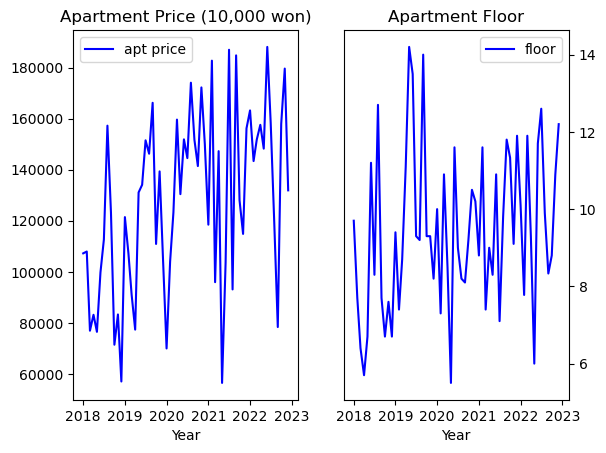

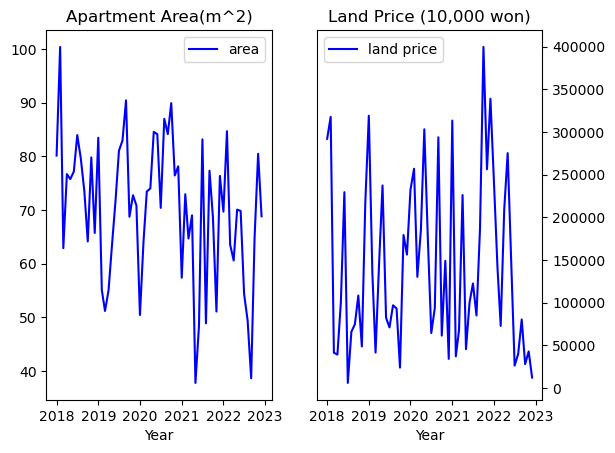

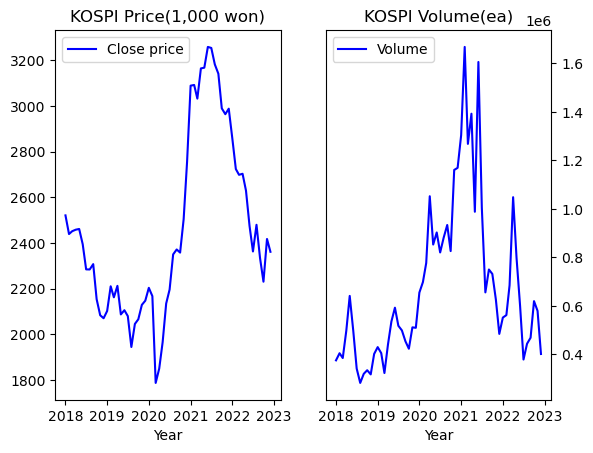

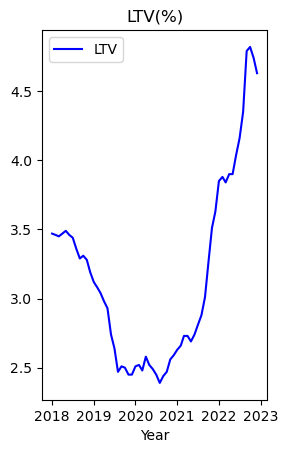

In [87]:
import pandas as pd
from matplotlib import pyplot as plt

df_aptE = pd.read_csv('부동산종합데이터.csv', encoding='cp949', low_memory=False,
                      converters={'아파트 거래금액(만원)': lambda x: int(x.replace(',', '')),
                                  '토지 거래금액(만원)': lambda x: int(x.replace(',', ''))})

df_aptE['거래연월'] = pd.to_datetime(df_aptE['거래연월'], format='%Y-%m')

# 월별 아파트 거래금액(만원) 평균 계산
df_price_mean = df_aptE.groupby('거래연월')['아파트 거래금액(만원)'].mean()
df_floor_mean = df_aptE.groupby('거래연월')['아파트 층'].mean()
df_area_mean = df_aptE.groupby('거래연월')['아파트 면적'].mean()
df_land_mean = df_aptE.groupby('거래연월')['토지 거래금액(만원)'].mean()
df_Close_avg = df_aptE.groupby('거래연월')['Close_avg'].mean()
df_Volume_avg = df_aptE.groupby('거래연월')['Volume_avg'].mean()
df_LTV = df_aptE.groupby('거래연월')['LTV'].mean()

# 날짜 형식 변경
df_price_mean.index = pd.to_datetime(df_price_mean.index, format='%Y-%m')
df_floor_mean.index = pd.to_datetime(df_floor_mean.index, format='%Y-%m')
df_area_mean.index = pd.to_datetime(df_area_mean.index, format='%Y-%m')
df_land_mean.index = pd.to_datetime(df_land_mean.index, format='%Y-%m')
df_Close_avg.index = pd.to_datetime(df_Close_avg.index, format='%Y-%m')
df_Volume_avg.index = pd.to_datetime(df_Volume_avg.index, format='%Y-%m')
df_LTV.index = pd.to_datetime(df_LTV.index, format='%Y-%m')

# 2018-01부터 2022-12까지의 데이터만 선택
start_date = pd.to_datetime('2018-01', format='%Y-%m')
end_date = pd.to_datetime('2022-12', format='%Y-%m')
df_price_mean = df_price_mean.loc[start_date:end_date]
df_floor_mean = df_floor_mean.loc[start_date:end_date]
df_area_mean = df_area_mean.loc[start_date:end_date]
df_land_mean = df_land_mean.loc[start_date:end_date]
df_Close_avg = df_Close_avg.loc[start_date:end_date]
df_Volume_avg = df_Volume_avg.loc[start_date:end_date]
df_LTV = df_LTV.loc[start_date:end_date]

# 꺾은선 그래프 그리기
plt.figure(1)
plt.subplot(1, 2, 1)
plt.plot(df_price_mean.index, df_price_mean.values, label='apt price', color='blue')
plt.xlabel('Year')
plt.title('Apartment Price (10,000 won)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_floor_mean.index, df_floor_mean.values, label='floor', color='blue')
plt.xlabel('Year')
plt.title('Apartment Floor')
ax = plt.gca()
ax.yaxis.tick_right()
plt.legend()

plt.figure(2)
plt.subplot(1, 2, 1)
plt.plot(df_area_mean.index, df_area_mean.values, label='area', color='blue')
plt.xlabel('Year')
plt.title('Apartment Area(m^2)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_land_mean.index, df_land_mean.values, label='land price', color='blue')
plt.xlabel('Year')
plt.title('Land Price (10,000 won)')
ax = plt.gca()
ax.yaxis.tick_right()
plt.legend()

plt.figure(3)
plt.subplot(1, 2, 1)
plt.plot(df_Close_avg.index, df_Close_avg.values, label='Close price', color='blue')
plt.xlabel('Year')
plt.title('KOSPI Price(1,000 won)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_Volume_avg.index, df_Volume_avg.values, label='Volume', color='blue')
plt.xlabel('Year')
plt.title('KOSPI Volume(ea)')
ax = plt.gca()
ax.yaxis.tick_right()
plt.legend()

plt.figure(4)
plt.subplot(1, 2, 1)
plt.plot(df_LTV.index, df_LTV.values, label='LTV', color='blue')
plt.xlabel('Year')
plt.title('LTV(%)')
plt.legend()

plt.show()

2) 시간을 고정하고, 수치형 데이터의 구간을 적절히 정하여, 히스토그램을 그려라.

### 진행사항
- 히스토그램은 도수를 표현하는거기 때문에 각 범주형 값들중 계절과 연식을 히스토그램으로 그렸습니다.

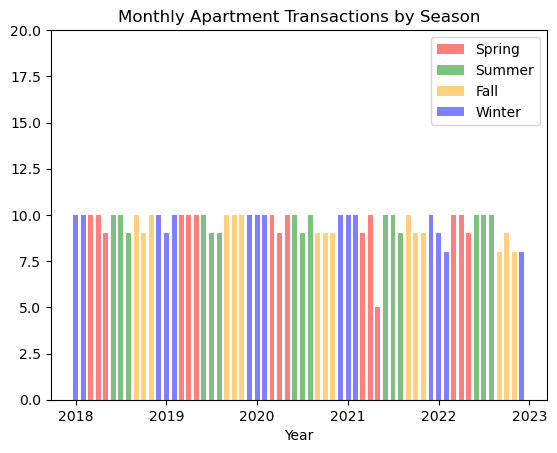

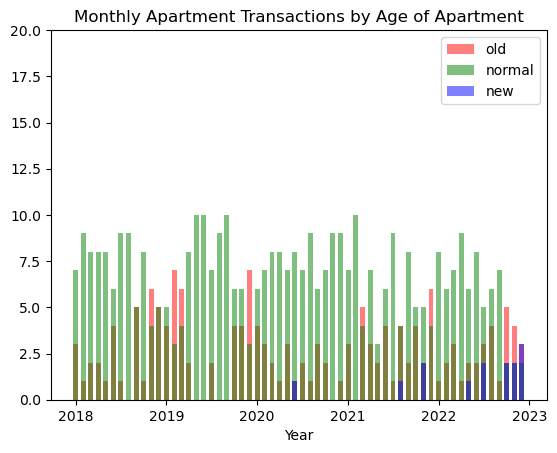

In [91]:
import pandas as pd
from matplotlib import pyplot as plt

df_aptE = pd.read_csv('부동산종합데이터.csv', encoding='cp949', low_memory=False,
                      converters={'아파트 거래금액(만원)': lambda x: int(x.replace(',', '')),
                                  '토지 거래금액(만원)': lambda x: int(x.replace(',', ''))})

df_aptE['거래연월'] = pd.to_datetime(df_aptE['거래연월'], format='%Y-%m')
df_aptE = df_aptE.drop_duplicates(subset=['거래연월', '아파트 거래금액(만원)'])

# '계절' 컬럼의 값이 null이 아닌 행만 선택
df_season = df_aptE.loc[df_aptE['계절'].notnull()]

# 각 계절에 해당하는 월별 거래건수를 계산
spring_count = df_season.loc[df_season['계절'] == '봄'].groupby('거래연월').size()
summer_count = df_season.loc[df_season['계절'] == '여름'].groupby('거래연월').size()
fall_count = df_season.loc[df_season['계절'] == '가을'].groupby('거래연월').size()
winter_count = df_season.loc[df_season['계절'] == '겨울'].groupby('거래연월').size()

# '연식' 컬럼의 값이 null이 아닌 행만 선택
df_buld = df_aptE.loc[df_aptE['연식'].notnull()]

# 각 연식에 해당하는 월별 거래건수를 계산
old_count = df_buld.loc[df_buld['연식'] == '구축'].groupby('거래연월').size()
normal_count = df_buld.loc[df_buld['연식'] == '일반'].groupby('거래연월').size()
new_count = df_buld.loc[df_buld['연식'] == '신축'].groupby('거래연월').size()

# 그래프 그리기
bar_width = 20.0
plt.figure(1)
plt.bar(spring_count.index, spring_count, label='Spring', color='red', width=bar_width, alpha = 0.5)
plt.bar(summer_count.index, summer_count, label='Summer', color='green', width=bar_width, alpha = 0.5)
plt.bar(fall_count.index, fall_count, label='Fall', color='orange', width=bar_width, alpha = 0.5)
plt.bar(winter_count.index, winter_count, label='Winter', color='blue', width=bar_width, alpha = 0.5)
plt.xlabel('Year')
plt.ylim(0, 20)
plt.title('Monthly Apartment Transactions by Season')
plt.legend()

plt.figure(2)
plt.bar(old_count.index, old_count, label='old', color='red', width=bar_width, alpha = 0.5)
plt.bar(normal_count.index, normal_count, label='normal', color='green', width=bar_width, alpha = 0.5)
plt.bar(new_count.index, new_count, label='new', color='blue', width=bar_width, alpha = 0.5)
plt.xlabel('Year')
plt.ylim(0, 20)
plt.title('Monthly Apartment Transactions by Age of Apartment')
plt.legend()

plt.show()

# 3. K-NN (1,2번 결과 활용)

1) 분류 문제의 정의 
- 예측하고자 하는 범주형 값을 정하시오. 
- 예측에 유용한 데이터 후보들을 20개 이상 나열해보시오. 


2) 종속변수 결정
분류 방법으로 예측하기 위한 범주형 종속변수를 기존 애트리뷰트에서 정하거나, 애트리뷰트를 추가하고 값을 생성하라.
- 예1) 강남구의 월단위 매매가격지수 증감여부(증가/감소)
- 예2) 계절 (봄, 여름, 가을, 겨울) 
- 예3) 월 (1월, 2월, ... 12월)  --> 1월이다/아니다, 2월이다/아니다


3) 독립변수 수집, 변형, 결정
- 종속변수의 범주형 분류값를 예측하기 위한 독립변수를 기존 애트리뷰트에서 정하거나, 변형하여 만들거나, 새로 수집하여 정한다.
예) 수치형 변수: 전세가격, 전세가격지수, 월세가격, 월세가격지수, 물가지수, 이자율
예) 범주형 변수: 전세의 증감여부, 월, 계절, 월세의 증감여부, 

4) 데이터의 분리: 학습, 검증, 테스트
- 데이터를 분리하는 프로그램을 작성하고, 
- 분리된 각 데이터의 통계값 을 출력하라. (데이터수, 평균, 표준편차, 중앙값, 사분위값,최대값, 최저값)

5) 데이터 모델
- 모델링 위한 코드를 작성하고,
- 성능지표를 정하라. (예: F1-score, Accuracy,...) 
- K값에 따른 성능지표를 구하여 학습데이터와 검증 데이터를 이용하여 출력하고, 
- 최고성능을 갖는 K값을 정하라.

6) 테스트 데이터를 이용하여 성능을 출력하는 코드와 결과를 포함하라. 



1) 분류 문제의 정의 
- 예측하고자 하는 범주형 값을 정하시오. 
- 예측에 유용한 데이터 후보들을 20개 이상 나열해보시오. 

### 진행사항

- 예측하고자 하는 범주형 값 : 강남구 아파트 매매가격 증감여부
- 예측에 유용한 데이터 후보 : 아파트 면적, 아파트 층수에 따른 구매 빈도, 토지 매매 가격, KOSPI 지수, KOSPI 증감, KOSPI 거래량, 계절,
                              건물연식, KOSPI 거래량 증감, 아파트 매매 가격 증감, 토지 매매 가격 증감,
                              계절 평균 아파트 매매 가격 증감, 건물연식 대비 아파트 구매 가격, LTV, LTV 증감율, 월 빈도수,
                              LTV와 구매 빈도, 월, 분기, 분기별 증감

4) 데이터의 분리: 학습, 검증, 테스트
- 데이터를 분리하는 프로그램을 작성하고, 
- 분리된 각 데이터의 통계값 을 출력하라. (데이터수, 평균, 표준편차, 중앙값, 사분위값,최대값, 최저값)

### 진행사항
- train 데이터와 test 데이터를 비교하는 것이 목적이므로 각각 하나씩 출력하도록 했습니다.
- 아파트 거래금액과 상관계수가 가장 높았던 아파트 층수와 아파트 면적을 k-nn 예측에 쓸 예정입니다.

In [112]:
# df.describe() 함수가 있지만 각 학습과 검증 데이터들의 통계값을 비교하는 것이 목적이므로 하나씩 출력합니다.
import pandas as pd
import math
from typing import Tuple

# 데이터를 나누는 함수
def split_data(data: pd.DataFrame, prob: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    data = data.sample(frac=1).reset_index(drop=True)  # shuffle data
    cut = int(len(data) * prob)
    train_data = data.iloc[:cut, :]
    test_data = data.iloc[cut:, :]
    return train_data, test_data

df_aptE = pd.read_csv('부동산종합데이터.csv', encoding='cp949', low_memory=False,
                      converters={'아파트 거래금액(만원)': lambda x: int(x.replace(',', '')),
                                  '토지 거래금액(만원)': lambda x: int(x.replace(',', ''))})

train_df, test_df = split_data(df_aptE, 0.75)

# 데이터 수
print('train_df의 row 수 : ', len(train_df))
print('test_df의 row 수 : ', len(test_df))

# 아파트 거래금액
# 평균
train_aptPrice = train_df['아파트 거래금액(만원)']
test_aptPrice = test_df['아파트 거래금액(만원)']
print('\ntran_df의 아파트 거래금액 평균 : ', train_aptPrice.mean())
print('test_df의 아파트 거래금액 평균 : ', test_aptPrice.mean())
# 표준편차
print('tran_df의 아파트 거래금액 표준편차 : ', train_aptPrice.std())
print('test_df의 아파트 거래금액 표준편차 : ', test_aptPrice.std())
# 중앙값
print('tran_df의 아파트 거래금액 중앙값 : ', train_aptPrice.median())
print('test_df의 아파트 거래금액 중앙값 : ', test_aptPrice.median())
# 사분위값
print('tran_df의 아파트 거래금액 Q1 : ', train_aptPrice.quantile(.25), ', Q2 : ', train_aptPrice.quantile(.5),
     ', Q3 : ', train_aptPrice.quantile(.75))
print('test_df의 아파트 거래금액 Q1 : ', test_aptPrice.quantile(.25), ', Q2 : ', test_aptPrice.quantile(.5),
     ', Q3 : ', test_aptPrice.quantile(.75))
# 최대값
print('tran_df의 아파트 거래금액 최대값 : ', train_aptPrice.max())
print('test_df의 아파트 거래금액 최대값 : ', test_aptPrice.max())
# 최저값
print('tran_df의 아파트 거래금액 최저값 : ', train_aptPrice.min())
print('test_df의 아파트 거래금액 최저값 : ', test_aptPrice.min())

# 아파트 층수
# 평균
train_floor = train_df['아파트 층']
test_floor = test_df['아파트 층']
print('\ntran_df의 아파트 층 평균 : ', train_floor.mean())
print('test_df의 아파트 층 평균 : ', test_floor.mean())
# 표준편차
print('tran_df의 아파트 층 표준편차 : ', train_floor.std())
print('test_df의 아파트 층 표준편차 : ', test_floor.std())
# 중앙값
print('tran_df의 아파트 층 중앙값 : ', train_floor.median())
print('test_df의 아파트 층 중앙값 : ', test_floor.median())
# 사분위값
print('tran_df의 아파트 층 Q1 : ', train_floor.quantile(.25), ', Q2 : ', train_floor.quantile(.5),
     ', Q3 : ', train_floor.quantile(.75))
print('test_df의 아파트 층 Q1 : ', test_floor.quantile(.25), ', Q2 : ', test_floor.quantile(.5),
     ', Q3 : ', test_floor.quantile(.75))
# 최대값
print('tran_df의 아파트 층 최대값 : ', train_floor.max())
print('test_df의 아파트 층 최대값 : ', test_floor.max())
# 최저값
print('tran_df의 아파트 층 최저값 : ', train_floor.min())
print('test_df의 아파트 층 최저값 : ', test_floor.min())

# 아파트 면적
# 평균
train_area = train_df['아파트 면적']
test_area = test_df['아파트 면적']
print('\ntran_df의 아파트 면적 평균 : ', train_area.mean())
print('test_df의 아파트 면적 평균 : ', test_area.mean())
# 표준편차
print('tran_df의 아파트 면적 표준편차 : ', train_area.std())
print('test_df의 아파트 면적 표준편차 : ', test_area.std())
# 중앙값
print('tran_df의 아파트 면적 중앙값 : ', train_area.median())
print('test_df의 아파트 면적 중앙값 : ', test_area.median())
# 사분위값
print('tran_df의 아파트 면적 Q1 : ', train_area.quantile(.25), ', Q2 : ', train_area.quantile(.5),
     ', Q3 : ', train_area.quantile(.75))
print('test_df의 아파트 면적 Q1 : ', test_area.quantile(.25), ', Q2 : ', test_area.quantile(.5),
     ', Q3 : ', test_area.quantile(.75))
# 최대값
print('tran_df의 아파트 면적 최대값 : ', train_area.max())
print('test_df의 아파트 면적 최대값 : ', test_area.max())
# 최저값
print('tran_df의 아파트 면적 최저값 : ', train_area.min())
print('test_df의 아파트 면적 최저값 : ', test_area.min())

# 증감
print('\ntran_df의 증감 value 갯수 : \n', train_df['증감'].value_counts())
print('tran_df의 증감 value 갯수 : \n', test_df['증감'].value_counts())

train_df의 row 수 :  6193
test_df의 row 수 :  2065

tran_df의 아파트 거래금액 평균 :  132781.94655255936
test_df의 아파트 거래금액 평균 :  132153.1147699758
tran_df의 아파트 거래금액 표준편차 :  90249.90971482203
test_df의 아파트 거래금액 표준편차 :  89973.53032963966
tran_df의 아파트 거래금액 중앙값 :  115000.0
test_df의 아파트 거래금액 중앙값 :  108000.0
tran_df의 아파트 거래금액 Q1 :  53000.0 , Q2 :  115000.0 , Q3 :  200000.0
test_df의 아파트 거래금액 Q1 :  52000.0 , Q2 :  108000.0 , Q3 :  200000.0
tran_df의 아파트 거래금액 최대값 :  373000
test_df의 아파트 거래금액 최대값 :  373000
tran_df의 아파트 거래금액 최저값 :  17700
test_df의 아파트 거래금액 최저값 :  17700

tran_df의 아파트 층 평균 :  9.612142741805265
test_df의 아파트 층 평균 :  9.694430992736077
tran_df의 아파트 층 표준편차 :  6.507652606930535
test_df의 아파트 층 표준편차 :  6.404946987221413
tran_df의 아파트 층 중앙값 :  8.0
test_df의 아파트 층 중앙값 :  8.0
tran_df의 아파트 층 Q1 :  4.0 , Q2 :  8.0 , Q3 :  14.0
test_df의 아파트 층 Q1 :  4.0 , Q2 :  8.0 , Q3 :  14.0
tran_df의 아파트 층 최대값 :  33
test_df의 아파트 층 최대값 :  33
tran_df의 아파트 층 최저값 :  1
test_df의 아파트 층 최저값 :  1

tran_df의 아파트 면적 평균 :  69.26132843533131
t

5) 데이터 모델
- 모델링 위한 코드를 작성하고,
- 성능지표를 정하라. (예: F1-score, Accuracy,...) 
- K값에 따른 성능지표를 구하여 학습데이터와 검증 데이터를 이용하여 출력하고, 
- 최고성능을 갖는 K값을 정하라.

### 진행사항
- 아파트 면적, 아파트 층 데이터를 이용해 증감을 예측하기로 하였습니다.

In [165]:
import math
from collections import Counter

def vector_subtract(v, w):
    """subtracts two vectors componentwise"""
    return [v_i - w_i for v_i, w_i in zip(v,w)]
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)
def squared_distance(v, w):
    return sum_of_squares(vector_subtract(v, w))

def distance(v, w):
    return math.sqrt(squared_distance(v, w))

def raw_majority_vote(labels):
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

def majority_vote(labels):
    """assumes that labels are ordered from nearest to farthest"""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest


def knn_classify(k, labeled_points, new_point):
    """each labeled point should be a pair (point, label)"""

    # order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,
                         key=lambda point_label: distance(point_label[0], new_point))

    # find the labels for the k closest
    k_nearest_labels = [label for _, label in by_distance[:k]]

    # and let them vote
    return majority_vote(k_nearest_labels)

# train 데이터 생성
train_list = [(a, b, c) for a, b, c in zip(train_df['아파트 면적'], train_df['아파트 층'], train_df['증감'])]
train_list = [([a, b], c) for a, b, c in train_list]

# test 데이터 생성
test_list = [[a, b] for a, b in zip(test_df['아파트 면적'], test_df['아파트 층'])]

# test 라벨 리스트 생성
y_test = list(test_df['증감'])

# k는 1부터 11까지 진행
for k in range(1, 11):
    num = 0
    for j in range(len(test_list)):
        prediction = knn_classify(k, train_list, test_list[j])
        if prediction == y_test[j] :
            num += 1
    # 정확도 계산
    accuracy = num / len(test_list)

    print("k =", k, ", 정확도:", accuracy)

k = 1 , 정확도: 0.9263922518159806
k = 2 , 정확도: 0.9263922518159806
k = 3 , 정확도: 0.9443099273607748
k = 4 , 정확도: 0.9443099273607748
k = 5 , 정확도: 0.9394673123486683
k = 6 , 정확도: 0.9394673123486683
k = 7 , 정확도: 0.9355932203389831
k = 8 , 정확도: 0.9355932203389831
k = 9 , 정확도: 0.9196125907990315
k = 10 , 정확도: 0.9196125907990315


6) 테스트 데이터를 이용하여 성능을 출력하는 코드와 결과를 포함하라. 

### 진행사항
- k는 4에서 가장 큰 정확도를 보였으므로 k=4일때의 성능을 구합니다.

In [166]:
num = 0
for i in range(len(test_list)):
    prediction = knn_classify(4, train_list, test_list[i])
    if prediction == y_test[i] :
        num += 1

# 정확도 계산
accuracy = num / len(test_list)

print("k = 4", ", 정확도:", accuracy)

k = 4 , 정확도: 0.9443099273607748


# 4. 의사결정트리 (1,2번 결과 활용)
- K-NN과 동일한 과정을 거쳐 제출하라.
- 단, 종속 애트리뷰는 동일하게 하라.

2) 종속변수 결정
분류 방법으로 예측하기 위한 범주형 종속변수를 기존 애트리뷰트에서 정하거나, 애트리뷰트를 추가하고 값을 생성하라.
- 예1) 강남구의 월단위 매매가격지수 증감여부(증가/감소)
- 예2) 계절 (봄, 여름, 가을, 겨울) 
- 예3) 월 (1월, 2월, ... 12월)  --> 1월이다/아니다, 2월이다/아니다


3) 독립변수 수집, 변형, 결정
- 종속변수의 범주형 분류값를 예측하기 위한 독립변수를 기존 애트리뷰트에서 정하거나, 변형하여 만들거나, 새로 수집하여 정한다.
예) 수치형 변수: 전세가격, 전세가격지수, 월세가격, 월세가격지수, 물가지수, 이자율
예) 범주형 변수: 전세의 증감여부, 월, 계절, 월세의 증감여부, 

4) 데이터의 분리: 학습, 검증, 테스트
- 데이터를 분리하는 프로그램을 작성하고, 
- 분리된 각 데이터의 통계값 을 출력하라. (데이터수, 평균, 표준편차, 중앙값, 사분위값,최대값, 최저값)

### 진행사항
- 면적을 기준으로 종속적인 범주형 데이터 연식, 계절을 사용하기로 하였습니다.
- 면적을 범주형 데이터로 바꾸기 위해 사분위값을 기준으로 바꿨습니다.
- 추가적으로 아파트 층을 범주형 데이터로 사용하기 위해 사분위값을 기준으로 바꿨습니다.

In [120]:
# df.describe() 함수가 있지만 각 학습과 검증 데이터들의 통계값을 비교하는 것이 목적이므로 하나씩 출력합니다.
import pandas as pd
import math
from typing import Tuple

# 데이터를 나누는 함수
def split_data(data: pd.DataFrame, prob: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    data = data.sample(frac=1).reset_index(drop=True)  # shuffle data
    cut = int(len(data) * prob)
    train_data = data.iloc[:cut, :]
    test_data = data.iloc[cut:, :]
    return train_data, test_data

# 아파트 면적 범주형으로 변환
def categorize_area(area):
    if area['아파트 면적'] < 40:
        return '좁음'
    elif area['아파트 면적'] >= 40 and area['아파트 면적'] <= 84:
        return '일반'
    else:
        return '넓음'

# 아파트 층 범주형으로 변환
def categorize_floor(floor):
    if floor['아파트 층'] < 4:
        return '저층'
    elif floor['아파트 층'] >= 4 and floor['아파트 층'] <= 14:
        return '일반'
    else:
        return '고층'

df_aptE = pd.read_csv('부동산종합데이터.csv', encoding='cp949', low_memory=False,
                      converters={'아파트 거래금액(만원)': lambda x: int(x.replace(',', '')),
                                  '토지 거래금액(만원)': lambda x: int(x.replace(',', ''))})

df_aptE['면적'] = df_aptE.apply(categorize_area, axis=1)
df_aptE['층'] = df_aptE.apply(categorize_floor, axis=1)

train_df, test_df = split_data(df_aptE, 0.75)

# 데이터 수
print('train_df의 row 수 : ', len(train_df))
print('test_df의 row 수 : ', len(test_df))

# 아파트 거래금액
# 평균
train_aptPrice = train_df['아파트 거래금액(만원)']
test_aptPrice = test_df['아파트 거래금액(만원)']
print('\ntran_df의 아파트 거래금액 평균 : ', train_aptPrice.mean())
print('test_df의 아파트 거래금액 평균 : ', test_aptPrice.mean())
# 표준편차
print('tran_df의 아파트 거래금액 표준편차 : ', train_aptPrice.std())
print('test_df의 아파트 거래금액 표준편차 : ', test_aptPrice.std())
# 중앙값
print('tran_df의 아파트 거래금액 중앙값 : ', train_aptPrice.median())
print('test_df의 아파트 거래금액 중앙값 : ', test_aptPrice.median())
# 사분위값
print('tran_df의 아파트 거래금액 Q1 : ', train_aptPrice.quantile(.25), ', Q2 : ', train_aptPrice.quantile(.5),
     ', Q3 : ', train_aptPrice.quantile(.75))
print('test_df의 아파트 거래금액 Q1 : ', test_aptPrice.quantile(.25), ', Q2 : ', test_aptPrice.quantile(.5),
     ', Q3 : ', test_aptPrice.quantile(.75))
# 최대값
print('tran_df의 아파트 거래금액 최대값 : ', train_aptPrice.max())
print('test_df의 아파트 거래금액 최대값 : ', test_aptPrice.max())
# 최저값
print('tran_df의 아파트 거래금액 최저값 : ', train_aptPrice.min())
print('test_df의 아파트 거래금액 최저값 : ', test_aptPrice.min())

# 아파트 면적
# 평균
train_area = train_df['아파트 면적']
test_area = test_df['아파트 면적']
print('\ntran_df의 아파트 면적 평균 : ', train_area.mean())
print('test_df의 아파트 면적 평균 : ', test_area.mean())
# 표준편차
print('tran_df의 아파트 면적 표준편차 : ', train_area.std())
print('test_df의 아파트 면적 표준편차 : ', test_area.std())
# 중앙값
print('tran_df의 아파트 면적 중앙값 : ', train_area.median())
print('test_df의 아파트 면적 중앙값 : ', test_area.median())
# 사분위값
print('tran_df의 아파트 면적 Q1 : ', train_area.quantile(.25), ', Q2 : ', train_area.quantile(.5),
     ', Q3 : ', train_area.quantile(.75))
print('test_df의 아파트 면적 Q1 : ', test_area.quantile(.25), ', Q2 : ', test_area.quantile(.5),
     ', Q3 : ', test_area.quantile(.75))
# 최대값
print('tran_df의 아파트 면적 최대값 : ', train_area.max())
print('test_df의 아파트 면적 최대값 : ', test_area.max())
# 최저값
print('tran_df의 아파트 면적 최저값 : ', train_area.min())
print('test_df의 아파트 면적 최저값 : ', test_area.min())

# 연식
print('\ntran_df의 연식 value 갯수 : \n', train_df['연식'].value_counts())
print('tran_df의 연식 value 갯수 : \n', test_df['연식'].value_counts())

# 면적
print('\ntran_df의 면적 value 갯수 : \n', train_df['면적'].value_counts())
print('tran_df의 면적 value 갯수 : \n', test_df['면적'].value_counts())

# 층
print('\ntran_df의 층 value 갯수 : \n', train_df['층'].value_counts())
print('tran_df의 층 value 갯수 : \n', test_df['층'].value_counts())

# 계절
print('\ntran_df의 계절 value 갯수 : \n', train_df['계절'].value_counts())
print('tran_df의 계절 value 갯수 : \n', test_df['계절'].value_counts())

# 증감
print('\ntran_df의 증감 value 갯수 : \n', train_df['증감'].value_counts())
print('tran_df의 증감 value 갯수 : \n', test_df['증감'].value_counts())

train_df의 row 수 :  6193
test_df의 row 수 :  2065

tran_df의 아파트 거래금액 평균 :  132127.70870337478
test_df의 아파트 거래금액 평균 :  134115.19467312348
tran_df의 아파트 거래금액 표준편차 :  89705.08445800775
test_df의 아파트 거래금액 표준편차 :  91578.93403007131
tran_df의 아파트 거래금액 중앙값 :  115000.0
test_df의 아파트 거래금액 중앙값 :  115000.0
tran_df의 아파트 거래금액 Q1 :  53000.0 , Q2 :  115000.0 , Q3 :  200000.0
test_df의 아파트 거래금액 Q1 :  54000.0 , Q2 :  115000.0 , Q3 :  200000.0
tran_df의 아파트 거래금액 최대값 :  373000
test_df의 아파트 거래금액 최대값 :  373000
tran_df의 아파트 거래금액 최저값 :  17700
test_df의 아파트 거래금액 최저값 :  17700

tran_df의 아파트 면적 평균 :  68.806540352011
test_df의 아파트 면적 평균 :  70.18497878934632
tran_df의 아파트 면적 표준편차 :  38.820470969504754
test_df의 아파트 면적 표준편차 :  40.29471858336255
tran_df의 아파트 면적 중앙값 :  59.8848
test_df의 아파트 면적 중앙값 :  59.95
tran_df의 아파트 면적 Q1 :  39.2 , Q2 :  59.8848 , Q3 :  84.96
test_df의 아파트 면적 Q1 :  39.53 , Q2 :  59.95 , Q3 :  84.97
tran_df의 아파트 면적 최대값 :  244.52
test_df의 아파트 면적 최대값 :  244.52
tran_df의 아파트 면적 최저값 :  12.1
test_df의 아파트 면적 최저값 :  12.1

5) 데이터 모델
- 모델링 위한 코드를 작성하고,
- 성능지표를 정하라. (예: F1-score, Accuracy,...) 
- K값에 따른 성능지표를 구하여 학습데이터와 검증 데이터를 이용하여 출력하고, 
- 최고성능을 갖는 K값을 정하라.

6) 테스트 데이터를 이용하여 성능을 출력하는 코드와 결과를 포함하라. 

In [121]:
from typing import NamedTuple, Union, Any, Dict, TypeVar, List, Optional
from collections import Counter
from collections import defaultdict
import math

T = TypeVar('T')  # generic type for inputs

class Leaf(NamedTuple):
    value: Any

class Split(NamedTuple):
    attribute: str
    subtrees: dict
    default_value: Any = None

DecisionTree = Union[Leaf, Split]

class Candidate(NamedTuple):
    area: str
    build: str
    floor : str
    season : str
    rate : Optional[str] = None
        
        
def entropy(class_probabilities: List[float]) -> float:
    """Given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2)
               for p in class_probabilities
               if p > 0)                     # ignore zero probabilities

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

def partition_entropy(subsets: List[List[Any]]) -> float:
    total_count = sum(len(subset) for subset in subsets)

    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)

def partition_by(inputs: List[T], attribute: str) -> Dict[Any, List[T]]:
    partitions: Dict[Any, List[T]] = defaultdict(list)
    for input in inputs:
        key = getattr(input, attribute)  # value of the specified attribute
        partitions[key].append(input)    # add input to the correct partition
    return partitions

def partition_entropy_by(inputs: List[Any],
                         attribute: str,
                         label_attribute: str) -> float:
    # Compute the entropy corresponding to the given partition
    # partitions consist of our inputs
    partitions = partition_by(inputs, attribute)

    # but partition_entropy needs just the class labels
    labels = [[getattr(input, label_attribute) for input in partition]
              for partition in partitions.values()]

    return partition_entropy(labels)

def classify(tree: DecisionTree, input: Any) -> Any:
    # If this is a leaf node, return its value
    if isinstance(tree, Leaf):
        return tree.value

    # Otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values of are subtrees to consider next
    subtree_key = getattr(input, tree.attribute)

    if subtree_key not in tree.subtrees:   # If no subtree for key,
        return tree.default_value          # return the default value.

    subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
    return classify(subtree, input)        # and use it to classify the input.


def build_tree_id3(inputs: List[Any],
                   split_attributes: List[str],
                   target_attribute: str) -> DecisionTree:
    # Count target labels
    label_counts = Counter(getattr(input, target_attribute)
                           for input in inputs)
    most_common_label = label_counts.most_common(1)[0][0]

    # If there's a unique label, predict it
    if len(label_counts) == 1:
        return Leaf(most_common_label)

    # If no split attributes left, return the majority label
    if not split_attributes:
        return Leaf(most_common_label)

    # Otherwise split by the best attribute
    def split_entropy(attribute: str) -> float:
        # Helper function for finding the best attribute
        return partition_entropy_by(inputs, attribute, target_attribute)

    best_attribute = min(split_attributes, key=split_entropy)

    partitions = partition_by(inputs, best_attribute)
    new_attributes = [a for a in split_attributes if a != best_attribute]

    # recursively build the subtrees
    subtrees = {attribute_value : build_tree_id3(subset,
                                                 new_attributes,
                                                 target_attribute)
                for attribute_value, subset in partitions.items()}

    return Split(best_attribute, subtrees, default_value=most_common_label)

# train 데이터 리스트 생성
train_list = [(a, b, c, d, e) for a, b, c, d, e in zip(train_df['면적'], train_df['연식'], train_df['층'],
                                                 train_df['계절'], train_df['증감'])]
# test 데이터 리스트 생성
test_list = [(a, b, c, d, e) for a, b, c, d, e in zip(test_df['면적'], test_df['연식'], test_df['층'],
                                                test_df['계절'], test_df['증감'])]

inputs = []

# 트리 훈련
for i in range(len(train_list)):
    train_tree = Candidate(train_list[i][0], train_list[i][0], train_list[i][2], train_list[i][3], train_list[i][4])
    inputs.append(train_tree)

# 트리 만들기
tree = build_tree_id3(inputs,
                      ['area', 'build', 'floor', 'season'],
                      'rate')

# 예측 및 정확도 출력
num = 0
for i in range(len(test_list)):
    prediction = classify(tree, Candidate(test_list[i][0], test_list[i][1], test_list[i][2], test_list[i][3]))
    if prediction == test_list[i][4] :
        num += 1
    
    accuracy = num / len(test_list)
    
print('정확도: ', accuracy)

정확도:  0.711864406779661
